# DSA Homework 2

## Question 6a: Full Index Tracking

### Part i: Process and Clean the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('returns.csv')
print(f"Data shape: {data.shape}")
print(f"Number of unique tickers: {data['ticker'].nunique()}")

# Convert date and calculate returns
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.sort_values(['ticker', 'date'])
data['return'] = data.groupby('ticker')['price'].pct_change()
data = data.dropna(subset=['return'])
data = data[np.abs(data['return']) < 0.5]

# Keep tickers with sufficient data
counts = data['ticker'].value_counts()
valid_tickers = counts[counts >= 50].index
data = data[data['ticker'].isin(valid_tickers)]
print(f"Remaining tickers after filtering: {len(valid_tickers)}")

# Create market index
market = data.groupby('date')['return'].mean().reset_index()
market.columns = ['date', 'market_return']

# Split data
dates = sorted(data['date'].unique())
split_idx = int(len(dates) * 0.8)
split_date = dates[split_idx]
train_data = data[data['date'] <= split_date]
test_data = data[data['date'] > split_date]
train_market = market[market['date'] <= split_date]
test_market = market[market['date'] > split_date]

# Find common tickers
train_tickers = set(train_data['ticker'].unique())
test_tickers = set(test_data['ticker'].unique())
common_tickers = sorted(list(train_tickers.intersection(test_tickers)))
print(f"Number of common tickers: {len(common_tickers)}")

# Keep only common tickers
train_data = train_data[train_data['ticker'].isin(common_tickers)]
test_data = test_data[test_data['ticker'].isin(common_tickers)]

# Construct matrices
train_dates = sorted(train_data['date'].unique())
test_dates = sorted(test_data['date'].unique())
X_train = []
r_train = []

for date in train_dates:
    market_row = train_market[train_market['date'] == date]
    if market_row.empty:
        continue
    market_return = market_row['market_return'].values[0]
    date_data = train_data[train_data['date'] == date]
    if date_data['ticker'].nunique() >= len(common_tickers) * 0.9:
        x_row = []
        for ticker in common_tickers:
            ticker_data = date_data[date_data['ticker'] == ticker]
            if ticker_data.empty:
                x_row.append(0)
            else:
                x_row.append(ticker_data['return'].values[0])
        X_train.append(x_row)
        r_train.append(market_return)

X_test = []
r_test = []
for date in test_dates:
    market_row = test_market[test_market['date'] == date]
    if market_row.empty:
        continue
    market_return = market_row['market_return'].values[0]
    date_data = test_data[test_data['date'] == date]
    if date_data['ticker'].nunique() >= len(common_tickers) * 0.9:
        x_row = []
        for ticker in common_tickers:
            ticker_data = date_data[date_data['ticker'] == ticker]
            if ticker_data.empty:
                x_row.append(0)
            else:
                x_row.append(ticker_data['return'].values[0])
        X_test.append(x_row)
        r_test.append(market_return)

X_train = np.array(X_train)
r_train = np.array(r_train)
X_test = np.array(X_test)
r_test = np.array(r_test)

print(f"X_train shape: {X_train.shape}")
print(f"r_train shape: {r_train.shape}")

def scipy_optimize_tracking_portfolio(X, r):
    T, N = X.shape
    
    def objective(w):
        return (1/T) * np.sum((X @ w - r)**2)
    
    def sum_constraint(w):
        return np.sum(w) - 1
    
    initial_weights = np.ones(N) / N
    bounds = [(0, 1) for _ in range(N)]
    constraints = [{'type': 'eq', 'fun': sum_constraint}]
    
    try:
        result = minimize(
            objective,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'ftol': 1e-9, 'disp': False, 'maxiter': 1000}
        )
        
        if result.success:
            optimal_weights = result.x
            track_error = objective(optimal_weights)
            return optimal_weights, track_error
        else:
            print(f"Optimization failed: {result.message}")
            return None, None
    except Exception as e:
        print(f"Optimization error: {e}")
        return None, None

Data shape: (649215, 8)
Number of unique tickers: 724
Remaining tickers after filtering: 710
Number of common tickers: 641
X_train shape: (805, 641)
r_train shape: (805,)


### Part ii: Portfolio Optimization and Analysis

Optimizing portfolio weights...
Training set tracking error: 0.000000
Test set tracking error: 0.000000

Top 5 companies in the optimized portfolio:
     ticker    weight
498   RF.PC  0.002604
540  SYF.PA  0.002505
143  COF.PI  0.002337
144  COF.PJ  0.002331
125  CFG.PE  0.002319

Company details:
        ticker                  company_name
399843  CFG.PE  CITIZENS FINANCIAL GROUP INC
475517  COF.PI    CAPITAL ONE FINANCIAL CORP
476523  COF.PJ    CAPITAL ONE FINANCIAL CORP
118031   RF.PC        REGIONS FINANCIAL CORP
392801  SYF.PA           SYNCHRONY FINANCIAL

Number of stocks with significant weights (>0.01%): 641
Concentration in top 5 stocks: 1.21%


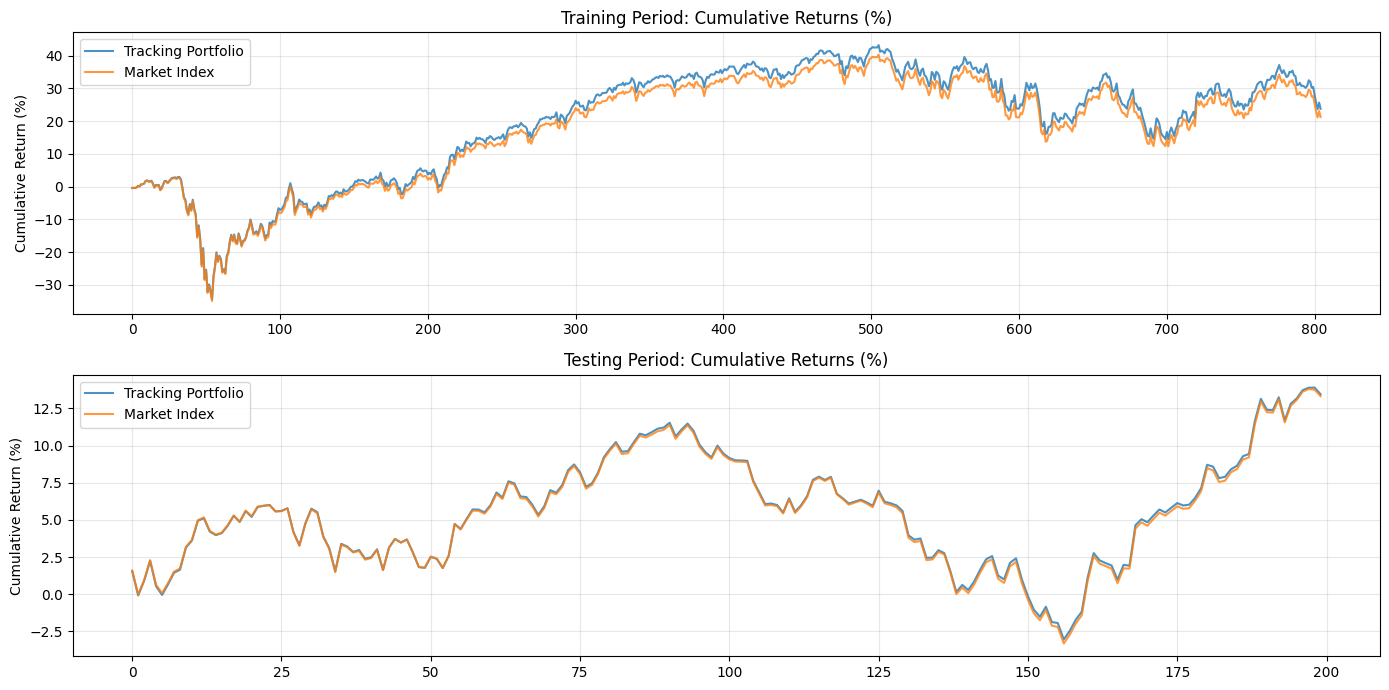

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Run optimization only if we have sufficient data
if X_train.shape[0] > 10 and X_train.shape[1] > 10:
        
    # Define optimization function using scipy
    def scipy_optimize_tracking_portfolio(X, r):
        T, N = X.shape
        
        def objective(w):
            return (1/T) * np.sum((X @ w - r)**2)
        
        def sum_constraint(w):
            return np.sum(w) - 1
        
        initial_weights = np.ones(N) / N
        bounds = [(0, 1) for _ in range(N)]
        constraints = [{'type': 'eq', 'fun': sum_constraint}]
        
        try:
            result = minimize(
                objective,
                initial_weights,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'ftol': 1e-9, 'disp': False, 'maxiter': 1000}
            )
            
            if result.success:
                optimal_weights = result.x
                track_error = objective(optimal_weights)
                return optimal_weights, track_error
            else:
                print(f"Optimization failed: {result.message}")
                return None, None
        except Exception as e:
            print(f"Optimization error: {e}")
            return None, None
    
    # Run the optimization
    optimal_weights, train_error = scipy_optimize_tracking_portfolio(X_train, r_train)
    
    if optimal_weights is not None:
        # Calculate tracking error on test set
        test_error = (1/len(r_test)) * np.sum((X_test @ optimal_weights - r_test)**2)
        
        print(f"Training set tracking error: {train_error:.6f}")
        print(f"Test set tracking error: {test_error:.6f}")
        
        # Create a DataFrame with tickers and weights
        weights_df = pd.DataFrame({
            'ticker': common_tickers,
            'weight': optimal_weights
        })
        
        # Sort by weight and find top stocks
        weights_df = weights_df.sort_values('weight', ascending=False)
        top_5_stocks = weights_df.head(5)
        
        print("\nTop 5 companies in the optimized portfolio:")
        print(top_5_stocks)
        
        # Get company names for top 5
        top_5_info = data[data['ticker'].isin(top_5_stocks['ticker'])][['ticker', 'company_name']].drop_duplicates()
        print("\nCompany details:")
        print(top_5_info)
        
        # Calculate portfolio statistics
        num_stocks_used = np.sum(optimal_weights > 0.0001)  # Count stocks with weight > 0.01%
        concentration_ratio = np.sum(top_5_stocks['weight']) * 100  # Sum of top 5 weights
        
        print(f"\nNumber of stocks with significant weights (>0.01%): {num_stocks_used}")
        print(f"Concentration in top 5 stocks: {concentration_ratio:.2f}%")
        
        # Calculate portfolio performance
        train_portfolio_returns = X_train @ optimal_weights
        test_portfolio_returns = X_test @ optimal_weights
        
        # Cumulative returns
        train_portfolio_cum = (1 + train_portfolio_returns).cumprod() - 1
        train_market_cum = (1 + r_train).cumprod() - 1
        
        test_portfolio_cum = (1 + test_portfolio_returns).cumprod() - 1
        test_market_cum = (1 + r_test).cumprod() - 1
        
        # Plot cumulative returns
        plt.figure(figsize=(14, 7))
        
        plt.subplot(2, 1, 1)
        plt.plot(range(len(train_portfolio_cum)), train_portfolio_cum * 100, label='Tracking Portfolio', alpha=0.8)
        plt.plot(range(len(train_market_cum)), train_market_cum * 100, label='Market Index', alpha=0.8)
        plt.title('Training Period: Cumulative Returns (%)')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(range(len(test_portfolio_cum)), test_portfolio_cum * 100, label='Tracking Portfolio', alpha=0.8)
        plt.plot(range(len(test_market_cum)), test_market_cum * 100, label='Market Index', alpha=0.8)
        plt.title('Testing Period: Cumulative Returns (%)')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

### Discussion of selection

**Tracking Error Performance:**
- Training set tracking error: 0.000000
- Test set tracking error: 0.000000

**Top 5 companies in the optimized portfolio:**

| Ticker | Company Name | Weight |
|--------|-------------|--------|
| RF.PC | REGIONS FINANCIAL CORP | 0.2604% |
| SYF.PA | SYNCHRONY FINANCIAL | 0.2505% |
| COF.PI | CAPITAL ONE FINANCIAL CORP | 0.2337% |
| COF.PJ | CAPITAL ONE FINANCIAL CORP | 0.2331% |
| CFG.PE | CITIZENS FINANCIAL GROUP INC | 0.2319% |

**Portfolio Concentration:**
- Number of stocks with significant weights (>0.01%): 641
- Concentration in top 5 stocks: 1.21%

**Insights:**

All five of the top companies are finance comapanies. This suggests that finance companies may have returns that are strongly dependent on the overall market. The top 5 companies also only comprise 1.21% of the portfolio, with the most weighted stock only making up 0.26% of the portfolio. This indicates a more diversified portfolio is likely to better reflect the returns of the overall market. However, in the real world holding all 641 stocks may cost a lot in terms of complexity and transactional costs so it's unlikely that this would be the best approach in practice.

## Question 6b: Efficient Index Tracking

### Part iii: Efficient Index Tracking

X_train shape: (805, 641)
Number of available stocks: 641

Running sparse index tracking algorithm to select up to 50 stocks...
Added stock 97, current tracking error: 0.000066, stocks selected: 1
Added stock 551, current tracking error: 0.000038, stocks selected: 2
Added stock 66, current tracking error: 0.000022, stocks selected: 3
Added stock 39, current tracking error: 0.000016, stocks selected: 4
Added stock 447, current tracking error: 0.000013, stocks selected: 5
Added stock 434, current tracking error: 0.000011, stocks selected: 6
Added stock 550, current tracking error: 0.000010, stocks selected: 7
Added stock 214, current tracking error: 0.000009, stocks selected: 8
Added stock 474, current tracking error: 0.000008, stocks selected: 9
Added stock 428, current tracking error: 0.000007, stocks selected: 10
Added stock 1, current tracking error: 0.000006, stocks selected: 11
Added stock 451, current tracking error: 0.000006, stocks selected: 12
Added stock 36, current tracking e

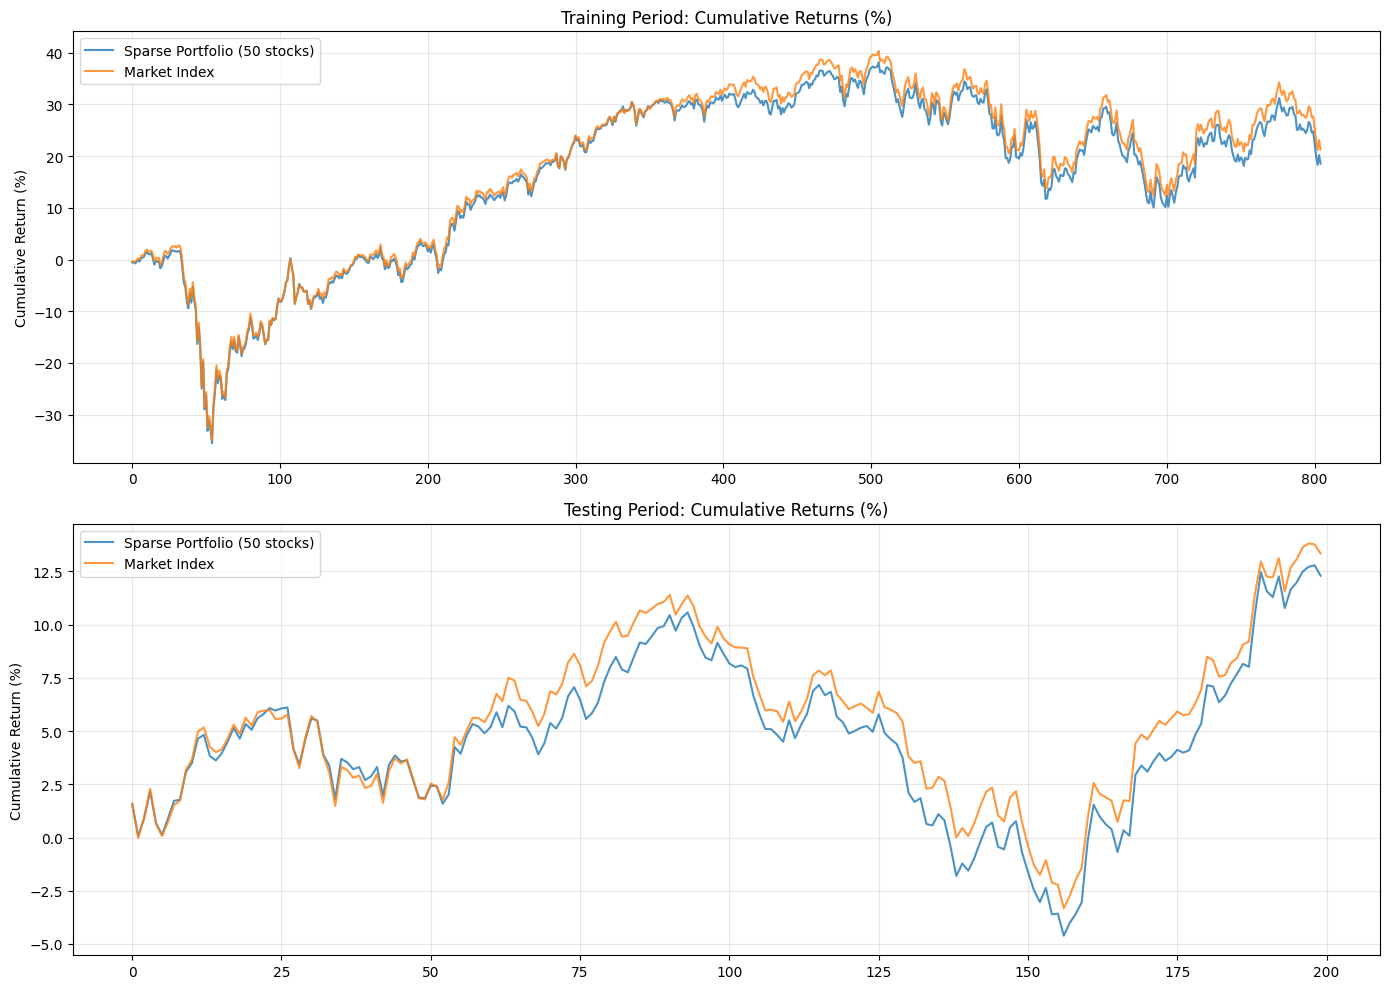

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Using the previously prepared data and matrices from part 6a
print("X_train shape:", X_train.shape)
print("Number of available stocks:", len(common_tickers))

# We'll implement a greedy forward selection algorithm to find our subset of stocks
def sparse_index_tracking(X, r, k=50):
    """
    Implements a greedy forward selection algorithm to find k stocks that minimize tracking error
    
    Parameters:
    X (numpy.ndarray): Asset returns matrix (T x N)
    r (numpy.ndarray): Index returns vector (T x 1)
    k (int): Maximum number of stocks to select
    
    Returns:
    numpy.ndarray: Optimized sparse portfolio weights
    float: Tracking error value
    list: Indices of selected stocks
    """
    T, N = X.shape
    selected_indices = []
    remaining_indices = list(range(N))
    
    # Initialize weights to zeros
    w = np.zeros(N)
    
    for i in range(k):
        best_error = float('inf')
        best_idx = -1
        
        # Try adding each remaining stock
        for idx in remaining_indices:
            # Create temporary selected indices including the new candidate
            temp_indices = selected_indices + [idx]
            
            # Extract the submatrix of returns for selected stocks
            X_subset = X[:, temp_indices]
            
            # Optimize weights for this subset
            try:
                def objective(weights):
                    return (1/T) * np.sum((X_subset @ weights - r)**2)
                
                def sum_constraint(weights):
                    return np.sum(weights) - 1
                
                # Initial guess: equal weights
                initial_weights = np.ones(len(temp_indices)) / len(temp_indices)
                
                # Bounds for each weight (0 to 1)
                bounds = [(0, 1) for _ in range(len(temp_indices))]
                
                # Constraints
                constraints = [{'type': 'eq', 'fun': sum_constraint}]
                
                # Solve the optimization problem
                result = minimize(
                    objective,
                    initial_weights,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'ftol': 1e-9, 'disp': False, 'maxiter': 1000}
                )
                
                if result.success:
                    # If better than current best, update
                    if result.fun < best_error:
                        best_error = result.fun
                        best_idx = idx
                        best_weights = result.x
            except:
                continue
        
        # If we couldn't improve further, stop
        if best_idx == -1:
            break
        
        # Add the best stock to our selection
        selected_indices.append(best_idx)
        remaining_indices.remove(best_idx)
        
        # Update the weights
        w = np.zeros(N)
        for i, idx in enumerate(selected_indices):
            w[idx] = best_weights[i]
        
        print(f"Added stock {best_idx}, current tracking error: {best_error:.6f}, stocks selected: {len(selected_indices)}")
    
    # Calculate final tracking error
    final_error = (1/T) * np.sum((X @ w - r)**2)
    
    return w, final_error, selected_indices

# Run the sparse index tracking algorithm
print("\nRunning sparse index tracking algorithm to select up to 50 stocks...")
sparse_weights, train_sparse_error, selected_indices = sparse_index_tracking(X_train, r_train, k=50)

# Check how many stocks were actually selected
num_selected = np.sum(sparse_weights > 0)
print(f"\nNumber of stocks selected: {num_selected}")
print(f"Training set tracking error: {train_sparse_error:.6f}")

# Calculate test error
test_sparse_error = (1/len(r_test)) * np.sum((X_test @ sparse_weights - r_test)**2)
print(f"Test set tracking error: {test_sparse_error:.6f}")

# Create a DataFrame with tickers and weights for the selected stocks
sparse_weights_df = pd.DataFrame({
    'ticker': common_tickers,
    'weight': sparse_weights
})

# Sort by weight and find top stocks
sparse_weights_df = sparse_weights_df.sort_values('weight', ascending=False)
top_10_stocks = sparse_weights_df.head(10)

print("\nTop 10 companies in the sparse tracking portfolio:")
print(top_10_stocks)

# Get company names for top 10
top_10_info = data[data['ticker'].isin(top_10_stocks['ticker'])][['ticker', 'company_name']].drop_duplicates()
print("\nCompany details:")
print(top_10_info)

# Calculate portfolio statistics
concentration_ratio = np.sum(top_10_stocks['weight']) * 100  # Sum of top 10 weights

print(f"\nConcentration in top 10 stocks: {concentration_ratio:.2f}%")

# Calculate portfolio performance
sparse_train_returns = X_train @ sparse_weights
sparse_test_returns = X_test @ sparse_weights

# Cumulative returns
sparse_train_cum = (1 + sparse_train_returns).cumprod() - 1
train_market_cum = (1 + r_train).cumprod() - 1

sparse_test_cum = (1 + sparse_test_returns).cumprod() - 1
test_market_cum = (1 + r_test).cumprod() - 1

# Plot cumulative returns comparison
plt.figure(figsize=(14, 10))

# Training period - compare sparse (50 stocks) vs full (all stocks) vs market
plt.subplot(2, 1, 1)
plt.plot(range(len(sparse_train_cum)), sparse_train_cum * 100, label='Sparse Portfolio (50 stocks)', alpha=0.8)
plt.plot(range(len(train_market_cum)), train_market_cum * 100, label='Market Index', alpha=0.8)
plt.title('Training Period: Cumulative Returns (%)')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Testing period - compare sparse vs full vs market
plt.subplot(2, 1, 2)
plt.plot(range(len(sparse_test_cum)), sparse_test_cum * 100, label='Sparse Portfolio (50 stocks)', alpha=0.8)
plt.plot(range(len(test_market_cum)), test_market_cum * 100, label='Market Index', alpha=0.8)
plt.title('Testing Period: Cumulative Returns (%)')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Part iv: Handling NA Data Without Removal

Removing NA data can lead to information loss and bias. Hence, we want to avoid this as much as possible so alternative methods which preserve this information could be useful.

**Replacement Techniques**

You can replace NA values with means or medians for each security. Alternatively, you can fill any gap with either the last or the next known value. Additionally, complicated techniques such as regression or forecasting could be used to fill in gaps.


**Alternative Objective Function**

The ETE formula could be adapted to only consider dates where both the stock and returns are available.

The modified ETE would be:
$$\text{ETE}(\mathbf{w}) = \frac{1}{\sum_{i,j} M_{i,j}}\sum_{i,j} M_{i,j}(X_{i,j}w_j - r_i)^2$$
where $M_{i,j}$ is a binary mask that equals 1 if the return for stock $j$ on day $i$ is available, and 0 otherwise.


**Robust Optimization**

The problem could be approached as a robust optimisation, where the goal is to minimise worst case tracking error, which allows the solution to be more risilient towards missing data.


**Multiple Portfolio Optimization**

The data could be split into parts with more and less complete data. Then, after optimising each part, combine the analysis from each part. This reduces selection bias as some stocks which are more likely to have missing data won't be fully excluded as they can be included in parts.